In [1]:
import pickle

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
tf.__version__

'1.15.0'

In [3]:

datadir = 'Data/27442/'

In [10]:
import glob

def read_mm(mfile):
    hm=np.memmap(mfile, dtype=np.int32, shape=(4,))
    shape = tuple(hm)
    del hm

    mm = np.memmap(mfile, dtype=np.float32, shape=shape)
    mm.shape
    #del mm
    amm = mm[:,:,:,[2, 0, 4, 0, 1]]
    amm = amm[:,:,:, [0,2,4]]
    del mm
    return amm

def read_data(globpattern):
    ifiles = glob.glob(globpattern) 
    ammdict = dict()
    for i in ifiles:
        amm = read_mm(i)
        amm_m = amm.mean(axis=(1,2), keepdims=True)
        amm_std = amm.std(axis=(1,2), keepdims=True)
        amm = (amm - amm_m)/amm_std
        print(i, amm.shape)
        ammdict[i.split('/')[-1]] = amm
   
    return ammdict

ammdict = read_data('Data/27442/*.mm')

Data/27442/27442_Snail5.mm (319, 64, 64, 3)
Data/27442/27442_Snail1.mm (380, 64, 64, 3)
Data/27442/27442_Snail4.mm (287, 64, 64, 3)
Data/27442/27442_Snail2.mm (313, 64, 64, 3)


In [11]:
ammdict.keys()

dict_keys(['27442_Snail5.mm', '27442_Snail1.mm', '27442_Snail4.mm', '27442_Snail2.mm'])

In [12]:
tf.reset_default_graph()
#dud = tf.get_variable('v1', shape=[2])
sess = tf.Session()


In [13]:
mmkeys = sorted(list(ammdict.keys()))
mmkeys
#plt.imshow(ammdict[mmkeys[0]][4,:,:,0], cmap='gray')

['27442_Snail1.mm', '27442_Snail2.mm', '27442_Snail4.mm', '27442_Snail5.mm']

In [14]:
cpdir = '../Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/'
checkpoint = 'best-checkpoint-21300'
if not cpdir.endswith('/'):
    cpdir += '/'

cpmeta = cpdir + checkpoint + '.meta'
saver = tf.train.import_meta_graph(cpmeta)
saver.restore(sess, cpdir + checkpoint)

'metric_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ../Checkpoints/Snail_Redo_for_metrics_7_classes/best-2019-08-16-10-46/best-checkpoint-21300


In [15]:
pq = 'dense_1/BiasAdd'.lower()
print(pq)
g = tf.get_default_graph()
ops = g.get_operations()
for op in ops:
    if pq in op.name.lower():
        print(op.name, op.outputs)

dense_1/biasadd
dense_1/BiasAdd [<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/BiasAddGrad [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/BiasAddGrad:0' shape=(128,) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/group_deps []
gradients/dense_1/BiasAdd_grad/tuple/control_dependency [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency:0' shape=(?, 128) dtype=float32>]
gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1 [<tf.Tensor 'gradients/dense_1/BiasAdd_grad/tuple/control_dependency_1:0' shape=(128,) dtype=float32>]


In [16]:
a = sess.graph.get_tensor_by_name('dense_1/BiasAdd:0')
b = sess.graph.get_tensor_by_name('LeakyRelu_13:0') #'dense_1/BiasAdd:0')
sm = sess.graph.get_tensor_by_name('Softmax:0')

softmax = sess.graph.get_tensor_by_name('Softmax:0')
batch = sess.graph.get_tensor_by_name('Placeholder:0')

In [17]:
a, b, sm

(<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'LeakyRelu_13:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Softmax:0' shape=(?, 7) dtype=float32>)

In [18]:
#data.max(axis=(0,1,2)), data.min(axis=(0,1,2))

In [19]:
for k, v in ammdict.items():
    #print(k, v.shape)
    amm = ammdict[k]
    print(len(amm))
    mask = np.any(np.isnan(amm), axis=(1,2,3))
    amm = amm[~mask]
    print(len(amm))
    ammdict[k] = amm

319
319
380
380
287
287
313
313


In [20]:
csvs = glob.glob('Data/Snail*.csv')

cluster_list = list()
for csv in csvs:
    print(csv)
    _clusters = pd.read_csv(csv, usecols=[0,1,2,3])
    _clusters.columns = ['ClusterID', 'EventID', 'FileName', 'index_in_file']
    print(_clusters.head())
    cluster_list.append(_clusters)

clustdf = pd.concat(cluster_list)


Data/Snail1_Phago_16_Nuc_processed.csv
   ClusterID  EventID                       FileName  index_in_file
0      27439    28963  Snail1_Phago_16_Nuc_processed              0
1      27439    28964  Snail1_Phago_16_Nuc_processed              1
2      27445    28965  Snail1_Phago_16_Nuc_processed              2
3      27444    28966  Snail1_Phago_16_Nuc_processed              3
4      27426    28967  Snail1_Phago_16_Nuc_processed              4
Data/Snail4_Phago_19_Nuc_processed.csv
   ClusterID  EventID                       FileName  index_in_file
0      27433   132567  Snail4_Phago_19_Nuc_processed              0
1      27439   132568  Snail4_Phago_19_Nuc_processed              1
2      27435   132569  Snail4_Phago_19_Nuc_processed              2
3      27439   132570  Snail4_Phago_19_Nuc_processed              3
4      27435   132571  Snail4_Phago_19_Nuc_processed              4
Data/Snail2_Phago_17_Nuc_processed.csv
   ClusterID  EventID                       FileName  index_in_file

In [21]:
pkls = glob.glob("Data/27442/*.pkl")
map_list = list()
for pf in pkls:
    with open(pf, 'rb') as pkl:
        _p = pickle.load(pkl)
        _map = pd.DataFrame.from_dict(_p, orient='index').reset_index()
        _map.columns = ['mmindex', 'index_in_file']
        _map['pkl'] = pf
        _map['replicate'] = pf.split('_')[1]
        map_list.append(_map)

mapdf = pd.concat(map_list)
mapdf.shape

(1299, 4)

In [23]:
clustdf['replicate'] = clustdf.FileName.map(lambda x: x.split('_')[0])
clustdf.shape, clustdf[clustdf.ClusterID == 27442].shape

((39206, 5), (1344, 5))

In [24]:
clustdf.ClusterID.unique().shape

(20,)

In [25]:
rmap = {p[6:12]:p for p in list(ammdict.keys())}
clustdf['mmfile'] = clustdf.replicate.map(rmap)


In [26]:
df = clustdf.merge(mapdf, on=['index_in_file', 'replicate'])
df.shape

(1299, 8)

In [27]:
df.tail()

,ClusterID,EventID,FileName,index_in_file,replicate,mmfile,mmindex,pkl
1294,27442,181708,Snail5_Phago_20_Nuc_processed,9794,Snail5,27442_Snail5.mm,314,Data/27442/27442_Snail5_index.pkl
1295,27442,181762,Snail5_Phago_20_Nuc_processed,9848,Snail5,27442_Snail5.mm,315,Data/27442/27442_Snail5_index.pkl
1296,27442,181767,Snail5_Phago_20_Nuc_processed,9853,Snail5,27442_Snail5.mm,316,Data/27442/27442_Snail5_index.pkl
1297,27442,181794,Snail5_Phago_20_Nuc_processed,9880,Snail5,27442_Snail5.mm,317,Data/27442/27442_Snail5_index.pkl
1298,27442,181824,Snail5_Phago_20_Nuc_processed,9910,Snail5,27442_Snail5.mm,318,Data/27442/27442_Snail5_index.pkl


In [28]:
images = sess.graph.get_tensor_by_name('Placeholder:0')
adflist = list()
d2list = list()
for k, v in ammdict.items():
    d2, r2, p2 = sess.run([a, b, sm], feed_dict={images:v[:, 16:48, 16:48, :]})
    d2list.append(d2)
    p2x = np.argmax(p2, axis=-1)
    s = k.split('_')
    mmfile = k #"{} {} {}".format(s[1], s[2], s[3][0])
    xdf = pd.DataFrame({'sm':p2x, 'smmax':p2.max(axis=-1), 'mmfile':mmfile})
    adflist.append(xdf)

adf = pd.concat(adflist, axis=0).reset_index()
adf = adf.rename(columns={'index':'mmindex'})
d2array = np.concatenate(d2list)
d2array.shape

(1299, 128)

In [29]:
adf.head()


,mmindex,sm,smmax,mmfile
0,0,5,0.518571,27442_Snail5.mm
1,1,0,0.986648,27442_Snail5.mm
2,2,5,0.952853,27442_Snail5.mm
3,3,0,0.938300,27442_Snail5.mm
4,4,4,0.639420,27442_Snail5.mm


In [30]:
df = df.merge(adf, on=['mmfile', 'mmindex'])
df.shape

(1299, 10)

In [31]:
np.histogram(df['sm'], bins=[0,.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])[0]

array([832,   3,   2,  82, 214,  61, 105])

In [32]:
df

,ClusterID,EventID,FileName,index_in_file,replicate,mmfile,mmindex,pkl,sm,smmax
0,27442,28976,Snail1_Phago_16_Nuc_processed,13,Snail1,27442_Snail1.mm,0,Data/27442/27442_Snail1_index.pkl,4,0.896522
1,27442,28977,Snail1_Phago_16_Nuc_processed,14,Snail1,27442_Snail1.mm,1,Data/27442/27442_Snail1_index.pkl,4,0.987990
2,27442,28996,Snail1_Phago_16_Nuc_processed,33,Snail1,27442_Snail1.mm,2,Data/27442/27442_Snail1_index.pkl,0,0.826630
3,27442,29061,Snail1_Phago_16_Nuc_processed,98,Snail1,27442_Snail1.mm,3,Data/27442/27442_Snail1_index.pkl,0,0.911246
4,27442,29081,Snail1_Phago_16_Nuc_processed,118,Snail1,27442_Snail1.mm,4,Data/27442/27442_Snail1_index.pkl,4,0.998236
...,...,...,...,...,...,...,...,...,...,...
1294,27442,181708,Snail5_Phago_20_Nuc_processed,9794,Snail5,27442_Snail5.mm,314,Data/27442/27442_Snail5_index.pkl,0,0.522187
1295,27442,181762,Snail5_Phago_20_Nuc_processed,9848,Snail5,27442_Snail5.mm,315,Data/27442/27442_Snail5_index.pkl,0,0.744095
1296,27442,181767,Snail5_Phago_20_Nuc_processed,9853,Snail5,27442_Snail5.mm,316,Data/27442/27442_Snail5_index.pkl,0,0.997512
1297,27442,181794,Snail5_Phago_20_Nuc_processed,9880,Snail5,27442_Snail5.mm,317,Data/27442/27442_Snail5_index.pkl,0,0.649435


In [33]:
odir = '/Users/cjw/Dropbox/phago/'
pmap = {'Snail1':f"{odir}Snail_Phago_1", 'Snail2':f"{odir}Snail_Phago_2",
        'Snail4':f"{odir}Snail_Phago_4", 'Snail5':f"{odir}Snail_Phago_5"}

df['odir'] = df.replicate.map(pmap)
df       

,ClusterID,EventID,FileName,index_in_file,replicate,mmfile,mmindex,pkl,sm,smmax,odir
0,27442,28976,Snail1_Phago_16_Nuc_processed,13,Snail1,27442_Snail1.mm,0,Data/27442/27442_Snail1_index.pkl,4,0.896522,/Users/cjw/Dropbox/phago/Snail_Phago_1
1,27442,28977,Snail1_Phago_16_Nuc_processed,14,Snail1,27442_Snail1.mm,1,Data/27442/27442_Snail1_index.pkl,4,0.987990,/Users/cjw/Dropbox/phago/Snail_Phago_1
2,27442,28996,Snail1_Phago_16_Nuc_processed,33,Snail1,27442_Snail1.mm,2,Data/27442/27442_Snail1_index.pkl,0,0.826630,/Users/cjw/Dropbox/phago/Snail_Phago_1
3,27442,29061,Snail1_Phago_16_Nuc_processed,98,Snail1,27442_Snail1.mm,3,Data/27442/27442_Snail1_index.pkl,0,0.911246,/Users/cjw/Dropbox/phago/Snail_Phago_1
4,27442,29081,Snail1_Phago_16_Nuc_processed,118,Snail1,27442_Snail1.mm,4,Data/27442/27442_Snail1_index.pkl,4,0.998236,/Users/cjw/Dropbox/phago/Snail_Phago_1
...,...,...,...,...,...,...,...,...,...,...,...
1294,27442,181708,Snail5_Phago_20_Nuc_processed,9794,Snail5,27442_Snail5.mm,314,Data/27442/27442_Snail5_index.pkl,0,0.522187,/Users/cjw/Dropbox/phago/Snail_Phago_5
1295,27442,181762,Snail5_Phago_20_Nuc_processed,9848,Snail5,27442_Snail5.mm,315,Data/27442/27442_Snail5_index.pkl,0,0.744095,/Users/cjw/Dropbox/phago/Snail_Phago_5
1296,27442,181767,Snail5_Phago_20_Nuc_processed,9853,Snail5,27442_Snail5.mm,316,Data/27442/27442_Snail5_index.pkl,0,0.997512,/Users/cjw/Dropbox/phago/Snail_Phago_5
1297,27442,181794,Snail5_Phago_20_Nuc_processed,9880,Snail5,27442_Snail5.mm,317,Data/27442/27442_Snail5_index.pkl,0,0.649435,/Users/cjw/Dropbox/phago/Snail_Phago_5


TiffTag 266: 0 is not a valid FILLORDER
TiffTag 266: 0 is not a valid FILLORDER
TiffTag 266: 0 is not a valid FILLORDER


(0, 0.99942374, '27442_Snail4.mm', 246)

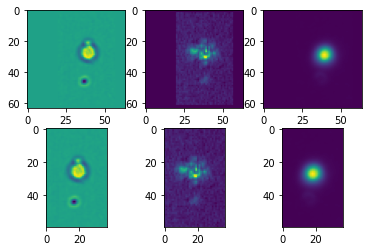

In [56]:


import tifffile
samp = df[(df.sm == 0) & (df.smmax > .92)].sample().iloc[0]
plt.subplot(2,3,1)
plt.imshow(ammdict[samp.mmfile][samp.mmindex][:,:,0])
plt.subplot(2,3,2)
plt.imshow(ammdict[samp.mmfile][samp.mmindex][:,:,1])
plt.subplot(2,3,3)
plt.imshow(ammdict[samp.mmfile][samp.mmindex][:,:,2])

opre = samp.odir.split("/")[-1]
if "Phago_1" in opre:
    opre = "Snail_Phago1"
plt.subplot(2,3,4)
ofile = f"{samp.odir}/{opre}_{samp.index_in_file}_Ch1.ome.tif"
ox = tifffile.imread(ofile)
plt.imshow(ox)
plt.subplot(2,3,5)
ofile = f"{samp.odir}/{opre}_{samp.index_in_file}_Ch6.ome.tif"
ox = tifffile.imread(ofile)
plt.imshow(ox)
plt.subplot(2,3,6)
ofile = f"{samp.odir}/{opre}_{samp.index_in_file}_Ch11.ome.tif"
ox = tifffile.imread(ofile)
plt.imshow(ox)
samp.sm, samp.smmax, samp.mmfile, samp.mmindex
#ammdict[samp.mmfile][samp.mmindex].shape

In [57]:
df.to_csv("Data/27442_class.csv")

In [69]:
rdir = "/n/core/cyto/_Data/Rohner/ROP/Imagestream Assay Data/Deep Learning_Feature_Analysis/Snail/Data for Classifier Analysis/phago only"
dirs = os.listdir(rdir)

glist = list()
for d in dirs:
    dd = rdir + '/' + d
    files = glob.glob(dd + '/*Ch1.*.tif')
    files = sorted(files, key=lambda x: int(os.path.basename(x).split("_")[2]))
    fdict = dict()
    #print(files[0:5])
    
    for index, f in enumerate(files):
        bf = os.path.basename(f)
        _sp = bf.split("_")
        cid = int(_sp[2])
        channel = int(_sp[3][2:].split(".")[0])
        glist.append({'index':index, 'cell_id':cid, 'directory':d, 'channel':channel})

gdf = pd.DataFrame(glist)

gdf.head()

    


,index,cell_id,directory,channel
0,0,158,PhagoOnly_R4,1
1,1,413,PhagoOnly_R4,1
2,2,503,PhagoOnly_R4,1
3,3,553,PhagoOnly_R4,1
4,4,606,PhagoOnly_R4,1


In [75]:
def mapdataset(x):
    #phago_only_PhagoOnly_R3.mm
    return "_".join(x.split("_")[2:])[:-3]

radf['directory'] = radf['dataset'].map(mapdataset)

In [78]:
merge_df = radf.merge(gdf, on=["index", "directory"])

In [81]:
merge_df[merge_df.directory == 'PhagoOnly_R2']

,index,sm,smmax,dataset,directory,cell_id,channel
72,0,0,0.402429,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,146,1
73,1,4,0.897734,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,320,1
74,2,0,0.377605,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,652,1
75,3,0,0.999063,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,724,1
76,4,0,0.904339,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,804,1
...,...,...,...,...,...,...,...
151,79,0,0.835413,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9237,1
152,80,0,0.999468,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9266,1
153,81,0,0.999452,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9586,1
154,82,0,0.999712,phago_only_PhagoOnly_R2.mm,PhagoOnly_R2,9692,1


In [82]:
merge_df.to_csv("snail_phago_classes.csv")

In [58]:
clustdf.groupby("ClusterID").agg('count')

,EventID,FileName,index_in_file,replicate,mmfile
ClusterID,,,,,
27426,3120,3120,3120,3120,3120
27427,3072,3072,3072,3072,3072
27428,768,768,768,768,768
27429,33,33,33,33,33
27430,228,228,228,228,228
27431,1057,1057,1057,1057,1057
27432,2585,2585,2585,2585,2585
27433,932,932,932,932,932
27434,564,564,564,564,564


In [61]:
csvs = glob.glob('Data/Snail*.csv')

cluster_list = list()
for csv in csvs:
    print(csv)
    _clusters = pd.read_csv(csv)
    # print(_clusters.head())
    cluster_list.append(_clusters)

xdf = pd.concat(cluster_list)


Data/Snail1_Phago_16_Nuc_processed.csv
Data/Snail4_Phago_19_Nuc_processed.csv
Data/Snail2_Phago_17_Nuc_processed.csv
Data/Snail5_Phago_20_Nuc_processed.csv


In [62]:
xdf.columns

Index(['ClusterID', 'EventID', 'File Name', 'Index in File', 'Event Name',
       'Comment', ':Area_Intensity_DHR',
       ':Bright.Detail.Intensity.R3_AdaptiveErode_BF_Ch02',
       ':Bright.Detail.Intensity.R3_AdaptiveErode_BF_Ch11',
       ':Circularity_AdaptiveErode_BF', ':Circularity_Morphology_DNA',
       ':Contrast_AdaptiveErode_BF_Ch01', ':Contrast_AdaptiveErode_BF_Ch06',
       ':Diameter_AdaptiveErode_BF', ':H.Energy.Mean_AdaptiveErode_BF_Ch01_5',
       ':H.Energy.Mean_Intensity_DHR_Ch07_5',
       ':H.Energy.Mean_Morphology_DNA_Ch11_5',
       ':H.Entropy.Mean_AdaptiveErode_BF_Ch01_5',
       ':H.Entropy.Mean_Intensity_Bac_Ch07_5',
       ':H.Entropy.Mean_Morphology_DNA_Ch11_5',
       ':Intensity_AdaptiveErode_BF_Ch02', ':Intensity_AdaptiveErode_BF_Ch06',
       ':Intensity_AdaptiveErode_BF_Ch07', ':Intensity_AdaptiveErode_BF_Ch11',
       ':Lobe.Count_Morphology_DNA_Ch11', ':Max.Pixel_Intensity_Bac_Ch07',
       ':Max.Pixel_Intensity_SSC_Ch06', ':Std.Dev_AdaptiveErode_BF

In [96]:
xdf['strclust'] = xdf['ClusterID'].map(lambda x: str(x))
xdf.tail()

,ClusterID,EventID,File Name,Index in File,Event Name,Comment,:Area_Intensity_DHR,:Bright.Detail.Intensity.R3_AdaptiveErode_BF_Ch02,:Bright.Detail.Intensity.R3_AdaptiveErode_BF_Ch11,:Circularity_AdaptiveErode_BF,...,:Intensity_AdaptiveErode_BF_Ch11,:Lobe.Count_Morphology_DNA_Ch11,:Max.Pixel_Intensity_Bac_Ch07,:Max.Pixel_Intensity_SSC_Ch06,:Std.Dev_AdaptiveErode_BF_Ch01,FDL-X,FDL-Y,MST-X,MST-Y,strclust
9939,27427,181853,Snail5_Phago_20_Nuc_processed,9939,NaN,NaN,0.0,0.321012,3.178688,3.098860,...,1.191548,4.076965,0.000000,0.878729,2.120472,NaN,NaN,0.817924,3.673491,27427
9940,27426,181854,Snail5_Phago_20_Nuc_processed,9940,NaN,NaN,0.0,0.595398,0.997471,2.304602,...,-0.329612,3.057724,0.000000,0.474531,2.651554,NaN,NaN,2.990670,3.649607,27426
9941,27435,181855,Snail5_Phago_20_Nuc_processed,9941,NaN,NaN,0.0,1.670251,1.039269,1.334622,...,1.313434,2.038482,0.000000,1.721476,3.808731,NaN,NaN,5.498769,-0.261390,27435
9942,27440,181856,Snail5_Phago_20_Nuc_processed,9942,NaN,NaN,0.0,0.451397,0.635440,1.575813,...,-0.646667,1.019241,0.000000,0.420826,2.192408,NaN,NaN,8.206894,-3.425385,27440
9943,27432,181857,Snail5_Phago_20_Nuc_processed,9943,NaN,NaN,0.0,0.898668,1.640637,1.476841,...,1.070689,1.019241,1.947851,0.000000,5.127920,NaN,NaN,-1.966189,4.718694,27432


In [124]:
sxdf = xdf.sample(6000)
xdata = sxdf.iloc[:,6:-5]
xdata.shape

(6000, 22)

In [125]:
from umap import UMAP
u = UMAP(local_connectivity=.2, learning_rate=4)
res = u.fit_transform(xdata)
sxdf['x'] = res[:,0]
sxdf['y'] = res[:,1]

0


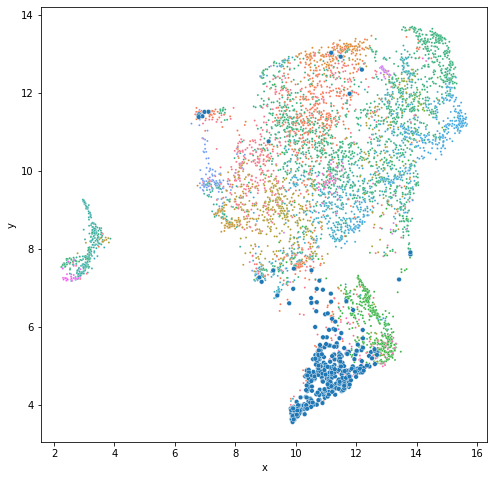

In [134]:
import seaborn as sns
plt.figure(figsize=(8,8))
g = sns.scatterplot(x='x', y='y', hue='strclust', data=sxdf, s=4, cmap='tab20')
plt.legend().remove()
sns.scatterplot(x='x', y='y', hue='strclust', data=sxdf[sxdf.ClusterID == 27432], s=22, c='blue')
plt.legend().remove()
print(len(sxdf[sxdf.strclust == 27442]))